In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


import pandas as pd
import os
import random
import shutil
from shutil import copy
from collections import defaultdict
import tensorflow as tf
import keras.backend as K
from patchify import patchify, unpatchify
import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam

---
### Training model to predict roots


In [2]:
def padder(image, patch_size):
    h = image.shape[0]
    w = image.shape[1]
    height_padding = ((h // patch_size) + 1) * patch_size - h
    width_padding = ((w // patch_size) + 1) * patch_size - w

    top_padding = int(height_padding/2)
    bottom_padding = height_padding - top_padding

    left_padding = int(width_padding/2)
    right_padding = width_padding - left_padding

    padded_image = cv2.copyMakeBorder(image, top_padding, bottom_padding, left_padding, right_padding, cv2.BORDER_CONSTANT, value=[0, 0, 0])

    return padded_image

In [3]:
def create_and_save_patches(dataset_type, patch_size, scaling_factor,mask_type):

    for image_path in glob.glob(f'Images for model/{mask_type}/{dataset_type}_images/{dataset_type}/*.png'):
        mask_suffix = f'_{mask_type}_mask.tif'
        path = f'Images for model/{mask_type}'
        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)

        image = cv2.imread(image_path)
        image = padder(image, patch_size)
        if scaling_factor != 1:
            image = cv2.resize(image, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        image_patch_path = image_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            image_patch_path_numbered = f'{image_patch_path[:-4]}_{i}.png'
            cv2.imwrite(image_patch_path_numbered, patch)

        mask_path = image_path.replace('images', 'masks').replace('.png', mask_suffix)
        mask = cv2.imread(mask_path, 0)
        mask = padder(mask, patch_size)
        if scaling_factor != 1:
            mask = cv2.resize(mask, (0,0), fx=scaling_factor, fy=scaling_factor)
        patches = patchify(mask, (patch_size, patch_size), step=patch_size)
        patches = patches.reshape(-1, patch_size, patch_size, 1)

        mask_patch_path = mask_path.replace(path, patch_dir)
        for i, patch in enumerate(patches):
            mask_patch_path_numbered = f'{mask_patch_path[:-4]}_{i}.png'
            cv2.imwrite(mask_patch_path_numbered, patch)

In [4]:
# Let's implement two custom metrics f1 score and iou
def f1(y_true, y_pred):
    def recall_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Positives = K.sum(K.round(K.clip(y_true, 0, 1)))
        recall = TP / (Positives+K.epsilon())
        return recall
    
    def precision_m(y_true, y_pred):
        TP = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
        Pred_Positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
        precision = TP / (Pred_Positives+K.epsilon())
        return precision
    
    precision, recall = precision_m(y_true, y_pred), recall_m(y_true, y_pred)
    
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def iou(y_true, y_pred):
    def f(y_true, y_pred):
        y_pred = tf.cast(y_pred>0.5,y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        total = K.sum(K.square(y_true),[1,2,3]) + K.sum(K.square(y_pred),[1,2,3])
        union = total - intersection
        return (intersection + K.epsilon()) / (union + K.epsilon())
    return K.mean(f(y_true, y_pred), axis=-1)

In [5]:
# U-Net model
# Author: Sreenivas Bhattiprolu
# This code is coming from the videos at the beginning
from keras.models import Model
import keras.backend as K
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda

def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS, lr):
# Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))
    s = inputs

    # Contraction path
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = MaxPooling2D((2, 2))(c1)
    
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = MaxPooling2D((2, 2))(c2)
     
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = MaxPooling2D((2, 2))(c3)
     
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c4)
    p4 = MaxPooling2D(pool_size=(2, 2))(c4)
     
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv2D(256, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c5)
    
    # Expansive path 
    u6 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)
     
    u7 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)
     
    u8 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)
     
    u9 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1], axis=3)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c9)
     
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c9)
     
    model = Model(inputs=[inputs], outputs=[outputs])
    optimizer = Adam(lr=lr) 
    model.compile(optimizer=optimizer,
                  loss='binary_crossentropy',
                  metrics=['accuracy', f1, iou])
    model.summary()
    
    return model

In [6]:
patch_size = 128
scaling_factor = 1

In [7]:
mask_type = 'root'

In [8]:
patch_dir = 'Images for model/root_patched'
for subdir in ['train_images/train', 'train_masks/train', 'val_images/val', 'val_masks/val','test_images/test','test_masks/test']:
    os.makedirs(os.path.join(patch_dir, subdir), exist_ok=True)

In [9]:
create_and_save_patches('train', patch_size, scaling_factor, mask_type= mask_type)
create_and_save_patches('val', patch_size, scaling_factor, mask_type= mask_type)

In [10]:
# Training images
train_image_datagen = ImageDataGenerator(rescale=1./255)

train_image_generator = train_image_datagen.flow_from_directory(
    f'{patch_dir}/train_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

# Training masks
train_mask_datagen = ImageDataGenerator()

train_mask_generator = train_mask_datagen.flow_from_directory(
    f'{patch_dir}/train_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42)

train_generator = zip(train_image_generator, train_mask_generator)

# val images
val_image_datagen = ImageDataGenerator(rescale=1./255)

val_image_generator = val_image_datagen.flow_from_directory(
    f'{patch_dir}/val_images',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

# val masks
val_mask_datagen = ImageDataGenerator()

val_mask_generator = val_mask_datagen.flow_from_directory(
    f'{patch_dir}/val_masks',
    target_size=(patch_size, patch_size),
    batch_size=16,
    class_mode=None,
    color_mode='grayscale',
    seed=42
)

val_generator = zip(val_image_generator, val_mask_generator)


Found 31680 images belonging to 1 classes.
Found 31680 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.
Found 7920 images belonging to 1 classes.


In [11]:
model_root = simple_unet_model(patch_size, patch_size, 1, lr=0.001)

from keras.callbacks import EarlyStopping

cb = EarlyStopping(monitor='val_iou',
                   patience=3   ,
                   restore_best_weights='True',
                   mode='max')

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 16  0           ['conv2d[0][0]']                 
                                )                                                             

c:\Users\domin\anaconda3\envs\tf\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
h_root = model_root.fit(
    train_generator,
    steps_per_epoch=len(train_image_generator),
    epochs=17,
    validation_data = val_generator,
    validation_steps = val_image_generator.samples//16
    # callbacks=[cb]
)

Epoch 1/17
1980/1980 [==============================] - 130s 61ms/step - loss: 0.0261 - accuracy: 0.9945 - f1: 0.1402 - iou: 0.8293 - val_loss: 0.0083 - val_accuracy: 0.9977 - val_f1: 0.3186 - val_iou: 0.8349
Epoch 2/17
1980/1980 [==============================] - 123s 62ms/step - loss: 0.0121 - accuracy: 0.9963 - f1: 0.4802 - iou: 0.8319 - val_loss: 0.0046 - val_accuracy: 0.9986 - val_f1: 0.4159 - val_iou: 0.8811
Epoch 3/17
1980/1980 [==============================] - 120s 61ms/step - loss: 0.0085 - accuracy: 0.9971 - f1: 0.5705 - iou: 0.8712 - val_loss: 0.0052 - val_accuracy: 0.9985 - val_f1: 0.3697 - val_iou: 0.8697
Epoch 4/17
1980/1980 [==============================] - 127s 64ms/step - loss: 0.0072 - accuracy: 0.9974 - f1: 0.6154 - iou: 0.8883 - val_loss: 0.0032 - val_accuracy: 0.9988 - val_f1: 0.4806 - val_iou: 0.9155
Epoch 5/17
1980/1980 [==============================] - 124s 63ms/step - loss: 0.0065 - accuracy: 0.9975 - f1: 0.6247 - iou: 0.9002 - val_loss: 0.0037 - val_accurac

In [13]:
input_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images'
output_dir = r'C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images_mask'

os.makedirs(output_dir, exist_ok=True)

image_files = [f for f in os.listdir(input_dir) if f.endswith('.tif')]

# Loop through each image file
for image_file in image_files:
    image_path = os.path.join(input_dir, image_file)
    
    # Read the image
    image = cv2.imread(image_path)
    image = padder(image, patch_size)
    
    patches = patchify(image, (patch_size, patch_size, 1), step=patch_size)
    
    i = patches.shape[0]
    j = patches.shape[1]
    
    patches = patches.reshape(-1, patch_size, patch_size, 1)
    patches.shape
    
    preds = model_root.predict(patches/255)
    
    preds = preds.reshape(i, j, 128, 128)
    
    predicted_mask = unpatchify(preds, (image.shape[0], image.shape[1]))
    
    # Cropping the predicted mask
    crop_top, crop_bottom, crop_left, crop_right = 33, 33, 11, 11
    predicted_mask = predicted_mask[crop_top:-crop_bottom, crop_left:-crop_right]
    
    # Apply thresholding to the predicted mask if needed
    # threshold = 0.5  
    # predicted_mask = (predicted_mask > threshold).astype(np.uint8)
    
    output_filename = image_file.replace('.tif', '_root_mask_predicted.png')
    output_file = os.path.join(output_dir, output_filename)
    cv2.imwrite(output_file, predicted_mask * 255)

25/25 [==============================] - 1s 31ms/step


In [14]:
def visualize_detected_instances(mask_path):
    combined_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    cv2.line(combined_mask, (1377, 0), (1350, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (1895, 0), (2000, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2415, 0), (2500, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    # cv2.line(combined_mask, (2920, 0), (3000, combined_mask.shape[0]), (0, 0, 0), thickness=5)

    combined_mask = cv2.medianBlur(combined_mask, 7)
    _, thresholded = cv2.threshold(combined_mask, 2, 255, cv2.THRESH_BINARY)

    
    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    
    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 5000]

    contours_to_use = sorted(filtered_contours, key=cv2.contourArea, reverse=True)[:len(filtered_contours)]

    instance_id = 0
    for contour in contours_to_use:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.putText(combined_mask, str(instance_id), (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 2)
        cv2.rectangle(combined_mask, (x, y), (x + w, y + h), (255, 255, 255), 3)  
        instance_id += 1


    plt.imshow(combined_mask, cmap='gray')
    plt.show()



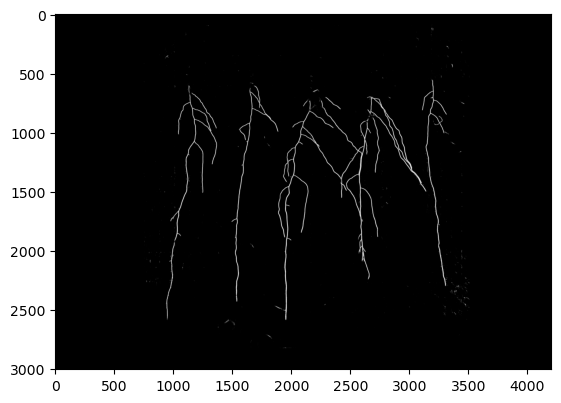

In [15]:
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images_mask\measurement_image_3_root_mask_predicted.png"
mask = cv2.imread(mask_path, 0)

plt.imshow(mask, cmap='gray')

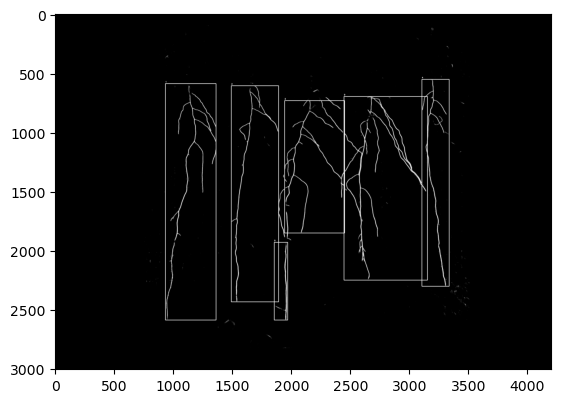

In [16]:
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images_mask\measurement_image_3_root_mask_predicted.png"
visualize_detected_instances(mask_path)

In [17]:
def save_detected_instances_with_crop(original_image_path, mask_path, save_path):
    original_image = cv2.imread(original_image_path)
    combined_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    cv2.line(combined_mask, (1377, 0), (1350, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (1895, 0), (2000, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2415, 0), (2500, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2920, 0), (3000, combined_mask.shape[0]), (0, 0, 0), thickness=5)

    _, thresholded = cv2.threshold(combined_mask, 5, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 5000]

    # Sort contours by their x-coordinate
    contours_to_use = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[0])

    instance_id = 0
    for contour in contours_to_use:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Crop corresponding regions from the original image
        instance_crop = original_image[y:y+h, x:x+w]
        
        instance_img_filename = f"instance_{instance_id}.png"
        instance_img_save_path = os.path.join(save_path, instance_img_filename)
        cv2.imwrite(instance_img_save_path, instance_crop)
        
        # Save the instance's mask 
        instance_mask_filename = f"instance_{instance_id}_mask.png"
        instance_mask_save_path = os.path.join(save_path, instance_mask_filename)
        cv2.imwrite(instance_mask_save_path, combined_mask[y:y+h, x:x+w])
        
        instance_id += 1



In [18]:
def save_detected_instances_with_crop_1(original_image_path, mask_path, save_path):
    original_image = cv2.imread(original_image_path)
    combined_mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    cv2.line(combined_mask, (1377, 0), (1350, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (1895, 0), (2000, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2415, 0), (2500, combined_mask.shape[0]), (0, 0, 0), thickness=5)
    cv2.line(combined_mask, (2920, 0), (3000, combined_mask.shape[0]), (0, 0, 0), thickness=5)

    _, thresholded = cv2.threshold(combined_mask, 5, 255, cv2.THRESH_BINARY)

    kernel = np.ones((5, 5), np.uint8)
    morphed = cv2.morphologyEx(thresholded, cv2.MORPH_CLOSE, kernel)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [contour for contour in contours if cv2.contourArea(contour) > 8000]

    # Sort contours by their x-coordinate
    contours_to_use = sorted(filtered_contours, key=lambda c: cv2.boundingRect(c)[0])

    instance_id = 0
    for contour in contours_to_use:
        x, y, w, h = cv2.boundingRect(contour)
        
        # Crop corresponding regions from the original image
        instance_crop = original_image[y:y+h, x:x+w]
        
        instance_img_filename = f"instance_{instance_id}.png"
        instance_img_save_path = os.path.join(save_path, instance_img_filename)
        cv2.imwrite(instance_img_save_path, instance_crop)
        
        # Save the instance's mask 
        instance_mask_filename = f"instance_{instance_id}_mask.png"
        instance_mask_save_path = os.path.join(save_path, instance_mask_filename)
        cv2.imwrite(instance_mask_save_path, combined_mask[y:y+h, x:x+w])
        
        instance_id += 1

In [19]:
original_image_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images\measurement_image_1.tif"
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images_mask\measurement_image_1_root_mask_predicted.png"
save_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\separeted_plants_1"
save_detected_instances_with_crop(original_image_path, mask_path, save_path)

In [20]:
original_image_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images\measurement_image_2.tif"
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images_mask\measurement_image_2_root_mask_predicted.png"
save_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\separeted_plants_2"
save_detected_instances_with_crop(original_image_path, mask_path, save_path)

In [21]:
original_image_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images\measurement_image_3.tif"
mask_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\images_mask\measurement_image_3_root_mask_predicted.png"
save_path = r"C:\Users\domin\Desktop\Year 2 Block B\2023-24b-fai2-adsai-DominikSzewczyk224180\1. Computer Vision\Task7\separeted_plants_3"
save_detected_instances_with_crop_1(original_image_path, mask_path, save_path)

---
### task 6


In [22]:
from skimage.morphology import skeletonize
from skimage.morphology import remove_small_objects


from skan import Skeleton, summarize
from skan.csr import skeleton_to_csgraph
from skan import draw

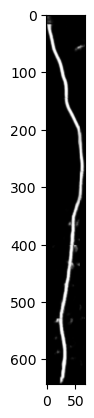

In [23]:
root_1 = cv2.imread(f'separeted_plants_1\instance_0_mask.png', 0)
plt.imshow(root_1, cmap='gray')

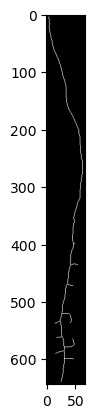

In [24]:
root_1 = cv2.medianBlur(root_1, 7)

skeleton = skeletonize(root_1)

cleaned_skeleton = remove_small_objects(skeleton, min_size=100, connectivity=2)

# Display the cleaned skeletonized image
plt.imshow(cleaned_skeleton, cmap='gray')


plt.show()

<Axes: >

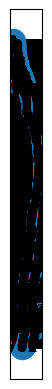

In [25]:
g1, c1 = skeleton_to_csgraph(cleaned_skeleton)
fig, ax = plt.subplots()
draw.overlay_skeleton_networkx(g1, np.transpose(c1), image=cleaned_skeleton, axis=ax)

In [26]:
simple_skeleton_branch_data = summarize(Skeleton(cleaned_skeleton))
simple_skeleton_branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,0,395,428.965512,1,1.0,0.0,4,5,399,47,4,5,399,47,397.226636
1,0,395,397,2.000000,1,1.0,0.0,399,47,399,49,399,47,399,49,2.000000
2,0,395,435,38.899495,2,1.0,0.0,399,47,435,42,399,47,435,42,36.345564
3,0,435,446,13.242641,1,1.0,0.0,435,42,436,54,435,42,436,54,12.041595
4,0,435,481,37.071068,2,1.0,0.0,435,42,470,37,435,42,470,37,35.355339
5,0,481,541,55.727922,2,1.0,0.0,470,37,521,27,470,37,521,27,51.971146
6,0,481,492,9.828427,1,1.0,0.0,470,37,472,46,470,37,472,46,9.219544
7,0,541,593,30.485281,1,1.0,0.0,521,27,537,41,521,27,537,41,21.260292
8,0,541,579,14.242641,2,1.0,0.0,521,27,534,24,521,27,534,24,13.341664
9,0,579,594,10.656854,1,1.0,0.0,534,24,538,15,534,24,538,15,9.848858


In [27]:
import networkx as nx

In [28]:
G = nx.from_pandas_edgelist(simple_skeleton_branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

In [29]:
node_positions = G.nodes

In [30]:
list(nx.connected_components(G))

[{0,
  395,
  397,
  435,
  446,
  481,
  492,
  541,
  579,
  593,
  594,
  619,
  627,
  632,
  662,
  682,
  695,
  706,
  721,
  762}]

In [32]:
path_list = nx.dijkstra_path(G, 0, 762, weight='branch-distance')
path_list

[0, 395, 435, 481, 541, 579, 619, 662, 682, 706, 762]

In [35]:
path_len = nx.dijkstra_path_length(G, 0, 762, weight='branch-distance')
path_len

686.1198410471451

In [36]:
first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

# Create a graph from the data
G = nx.from_pandas_edgelist(
    simple_skeleton_branch_data,
    'node-id-src',
    'node-id-dst',
    ['branch-distance']
)

# Compute the distance using Dijkstra's algorithm
path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
print(f"Distance between the first and last nodes: {path_len}")

Distance between the first and last nodes: 686.1198410471451


In [37]:
import pandas as pd
import networkx as nx

# Assuming 'simple_skeleton_branch_data' is your DataFrame

# Create a graph from the data
G = nx.from_pandas_edgelist(
    simple_skeleton_branch_data,
    'node-id-src',
    'node-id-dst',
    ['branch-distance']
)

# Get the first and last nodes from the DataFrame
first_node = simple_skeleton_branch_data.iloc[0]['node-id-src']
last_node = simple_skeleton_branch_data.iloc[-1]['node-id-dst']

# Get the path between the first and last nodes
path = nx.dijkstra_path(G, first_node, last_node, weight='branch-distance')

# Filter out nodes that are not part of the main root path
main_root_nodes = set(path)

# Iterate through the DataFrame to find secondary root distances
for _, row in simple_skeleton_branch_data.iterrows():
    src_node = row['node-id-src']
    dst_node = row['node-id-dst']
    distance = row['branch-distance']
    
    # Check if the nodes are not part of the main root path
    if src_node not in main_root_nodes or dst_node not in main_root_nodes:
        print(f"Branch distance between nodes {src_node} and {dst_node}: {distance}")



Branch distance between nodes 395.0 and 397.0: 2.0
Branch distance between nodes 435.0 and 446.0: 13.242640687119286
Branch distance between nodes 481.0 and 492.0: 9.82842712474619
Branch distance between nodes 541.0 and 593.0: 30.485281374238575
Branch distance between nodes 579.0 and 594.0: 10.656854249492381
Branch distance between nodes 619.0 and 627.0: 9.82842712474619
Branch distance between nodes 632.0 and 662.0: 29.899494936611667
Branch distance between nodes 682.0 and 695.0: 15.656854249492381
Branch distance between nodes 706.0 and 721.0: 16.82842712474619


## second plant

In [38]:
root_2 = cv2.imread(f'separeted_plants_2\instance_3_mask.png', 0)

In [39]:
root_2 = cv2.medianBlur(root_2, 7)

skeleton = skeletonize(root_2)

cleaned_skeleton = remove_small_objects(skeleton, min_size=100, connectivity=2)

In [40]:
simple_skeleton_branch_data = summarize(Skeleton(cleaned_skeleton))
simple_skeleton_branch_data

,skeleton-id,node-id-src,node-id-dst,branch-distance,branch-type,mean-pixel-value,stdev-pixel-value,image-coord-src-0,image-coord-src-1,image-coord-dst-0,image-coord-dst-1,coord-src-0,coord-src-1,coord-dst-0,coord-dst-1,euclidean-distance
0,0,1,38,22.727922,1,1.0,0.0,0,63,18,61,0,63,18,61,18.110770
1,0,2,38,25.798990,1,1.0,0.0,0,77,18,61,0,77,18,61,24.083189
2,0,38,107,64.071068,2,1.0,0.0,18,61,80,60,18,61,80,60,62.008064
3,0,107,113,12.828427,1,1.0,0.0,80,60,82,48,80,60,82,48,12.165525
4,0,107,183,71.485281,2,1.0,0.0,80,60,149,58,80,60,149,58,69.028979
5,0,183,1002,784.722871,2,1.0,0.0,149,58,900,8,149,58,900,8,752.662607
6,0,183,306,81.669048,1,1.0,0.0,149,58,204,104,149,58,204,104,71.700767
7,0,1002,1020,15.071068,1,1.0,0.0,900,8,905,21,900,8,905,21,13.928388
8,0,1002,1048,35.071068,1,1.0,0.0,900,8,933,3,900,8,933,3,33.376639


In [43]:
G = nx.from_pandas_edgelist(simple_skeleton_branch_data, source='node-id-src', target='node-id-dst', edge_attr='branch-distance')

In [44]:
path_len = nx.dijkstra_path_length(G, 1, 1002, weight='branch-distance')
path_len

943.0071426749371

In [46]:
def measure_root_distances(data):
    first_node = data.loc[0, 'node-id-src']
    last_node = data.loc[len(data) - 1, 'node-id-dst']

    G = nx.from_pandas_edgelist(
        data,
        'node-id-src',
        'node-id-dst',
        ['branch-distance']
    )

    path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
    print(f"Primary root length: {path_len}")

    first_node = data.iloc[0]['node-id-src']
    last_node = data.iloc[-1]['node-id-dst']

    path = nx.dijkstra_path(G, first_node, last_node, weight='branch-distance')
    main_root_nodes = set(path)

    for _, row in data.iterrows():
        src_node = row['node-id-src']
        dst_node = row['node-id-dst']
        distance = row['branch-distance']

        if src_node not in main_root_nodes or dst_node not in main_root_nodes:
            print(f"Lateral root lengths: {distance}")

In [47]:
measure_root_distances(simple_skeleton_branch_data)

Primary root length: 978.0782104868026
Lateral root lengths: 25.798989873223338
Lateral root lengths: 12.828427124746192
Lateral root lengths: 81.6690475583121
Lateral root lengths: 15.071067811865477


### final funcion

In [70]:
def process_and_measure(image_path):
    # Read the image
    root_img = cv2.imread(image_path, 0)
    root_img = cv2.medianBlur(root_img, 7)

    # Skeletonize and clean the skeleton
    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=100, connectivity=2)

    # Generate the simple_skeleton_branch_data
    simple_skeleton_branch_data = summarize(Skeleton(cleaned_skeleton))

    # Measure root distances
    first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
    last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

    G = nx.from_pandas_edgelist(
        simple_skeleton_branch_data,
        'node-id-src',
        'node-id-dst',
        ['branch-distance']
    )

    path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
    print(f"Primary root length: {path_len}")

    first_node = simple_skeleton_branch_data.iloc[0]['node-id-src']
    last_node = simple_skeleton_branch_data.iloc[-1]['node-id-dst']

    path = nx.dijkstra_path(G, first_node, last_node, weight='branch-distance')
    main_root_nodes = set(path)

    for _, row in simple_skeleton_branch_data.iterrows():
        src_node = row['node-id-src']
        dst_node = row['node-id-dst']
        distance = row['branch-distance']

        if src_node not in main_root_nodes or dst_node not in main_root_nodes:
            print(f"Lateral root lengths: {distance}")

# Usage example:
image_path = f'separeted_plants_1\instance_0_mask.png'
process_and_measure(image_path)


Primary root length: 686.1198410471451
Lateral root lengths: 2.0
Lateral root lengths: 13.242640687119286
Lateral root lengths: 9.82842712474619
Lateral root lengths: 30.485281374238575
Lateral root lengths: 10.656854249492381
Lateral root lengths: 9.82842712474619
Lateral root lengths: 29.899494936611667
Lateral root lengths: 15.656854249492381
Lateral root lengths: 16.82842712474619


In [71]:
def process_and_measure(image_path):
    # Read the image
    root_img = cv2.imread(image_path, 0)
    root_img = cv2.medianBlur(root_img, 7)

    # Skeletonize and clean the skeleton
    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=500, connectivity=2)

    # Generate the simple_skeleton_branch_data
    simple_skeleton_branch_data = summarize(Skeleton(cleaned_skeleton))

    # Measure root distances
    first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
    last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

    G = nx.from_pandas_edgelist(
        simple_skeleton_branch_data,
        'node-id-src',
        'node-id-dst',
        ['branch-distance']
    )

    path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
    print(f"Primary root length: {path_len}")

image_path = f'separeted_plants_3\instance_3_mask.png'
process_and_measure(image_path)

Primary root length: 1679.3523804664974


In [72]:
def process_and_measure(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None
    
    root_img = cv2.imread(image_path, 0)
    if root_img is None:
        print(f"Unable to read image: {image_path}")
        return None
    
    root_img = cv2.medianBlur(root_img, 7)

    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=500, connectivity=2)

    simple_skeleton_branch_data = summarize(Skeleton(cleaned_skeleton))

    first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
    last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

    G = nx.from_pandas_edgelist(
        simple_skeleton_branch_data,
        'node-id-src',
        'node-id-dst',
        ['branch-distance']
    )

    path_len = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')
    return path_len

# Process and measure lengths for each plant instance
data = []
plant_counter = 1
for folder_index in range(1, 4):
    folder_path = f"separeted_plants_{folder_index}"
    for instance_index in range(5):
        image_path = os.path.join(folder_path, f"instance_{instance_index}_mask.png")
        length = process_and_measure(image_path)
        if length is not None:
            data.append({'Plant': f"Plant {plant_counter}", 'Length': length})
            plant_counter += 1
        else:
            print(f"Skipping instance: {image_path} due to error.")

# Save lengths in a table
length_table_predicted = pd.DataFrame(data)
print(length_table_predicted)


       Plant       Length
0    Plant 1   686.119841
1    Plant 2  1053.901587
2    Plant 3   890.634560
3    Plant 4  1032.688384
4    Plant 5   921.901587
5    Plant 6  1113.416306
6    Plant 7  1116.688384
7    Plant 8  1075.303607
8    Plant 9   978.078210
9   Plant 10  1055.717821
10  Plant 11  2193.040764
11  Plant 12  1931.624458
12  Plant 13  1315.548340
13  Plant 14  1679.352380
14  Plant 15   490.102597


In [73]:
data = {
    'Plant': [f"Plant {i+1}" for i in range(15)],
    'Length': [675.321, 1036.375, 875.321, 973.233, 874.931, 988.676, 1103.688, 
               969.534, 946.25, 1004.09, 2087.987, 1832.311, 2000.276, 1685.997, 1851.909]
}

length_table_truth = pd.DataFrame(data)
print(length_table_truth)


       Plant    Length
0    Plant 1   675.321
1    Plant 2  1036.375
2    Plant 3   875.321
3    Plant 4   973.233
4    Plant 5   874.931
5    Plant 6   988.676
6    Plant 7  1103.688
7    Plant 8   969.534
8    Plant 9   946.250
9   Plant 10  1004.090
10  Plant 11  2087.987
11  Plant 12  1832.311
12  Plant 13  2000.276
13  Plant 14  1685.997
14  Plant 15  1851.909


I challenged myself and calculate sMAPE for 3 images

In [74]:
# Convert to pandas DataFrame
length_table_predicted = pd.DataFrame(length_table_predicted)
length_table_truth = pd.DataFrame(length_table_truth)

# Calculate sMAPE
def calculate_smape(predictions, truth):
    n = len(predictions)
    smape = (100 / n) * np.sum(2 * np.abs(predictions - truth) / (np.abs(predictions) + np.abs(truth)))
    return smape

# Extract lengths for calculation
predicted_lengths = length_table_predicted['Length']
true_lengths = length_table_truth['Length']

# Calculate sMAPE
smape_value = calculate_smape(predicted_lengths, true_lengths)
print(f"The sMAPE between predicted and true lengths is: {smape_value:.2f}%")

The sMAPE between predicted and true lengths is: 14.40%


Now for Lateral roots

In [75]:
def process_and_measure(image_path):
    if not os.path.exists(image_path):
        print(f"Image not found: {image_path}")
        return None, None
    
    root_img = cv2.imread(image_path, 0)
    if root_img is None:
        print(f"Unable to read image: {image_path}")
        return None, None
    
    root_img = cv2.medianBlur(root_img, 7)

    skeleton = skeletonize(root_img)
    cleaned_skeleton = remove_small_objects(skeleton, min_size=500, connectivity=2)

    simple_skeleton_branch_data = summarize(Skeleton(cleaned_skeleton))

    first_node = simple_skeleton_branch_data.loc[0, 'node-id-src']
    last_node = simple_skeleton_branch_data.loc[len(simple_skeleton_branch_data) - 1, 'node-id-dst']

    G = nx.from_pandas_edgelist(
        simple_skeleton_branch_data,
        'node-id-src',
        'node-id-dst',
        ['branch-distance']
    )

    # Measure primary root length
    primary_root_length = nx.dijkstra_path_length(G, first_node, last_node, weight='branch-distance')

    # Measure lateral root lengths
    lateral_root_lengths = []
    main_root_nodes = set(nx.dijkstra_path(G, first_node, last_node, weight='branch-distance'))
    for _, row in simple_skeleton_branch_data.iterrows():
        src_node = row['node-id-src']
        dst_node = row['node-id-dst']
        distance = row['branch-distance']

        if src_node not in main_root_nodes or dst_node not in main_root_nodes:
            lateral_root_lengths.append(distance)

    return primary_root_length, lateral_root_lengths

# Process and measure lengths for each plant instance
data = []
plant_counter = 1
for folder_index in range(1, 4):
    folder_path = f"separeted_plants_{folder_index}"
    for instance_index in range(5):
        image_path = os.path.join(folder_path, f"instance_{instance_index}_mask.png")
        primary_length, lateral_lengths = process_and_measure(image_path)
        if primary_length is not None and lateral_lengths is not None:
            data.append({
                'Plant': f"Plant {plant_counter}",
                'Primary Length': primary_length,
                'Sum of Lateral Lengths': sum(lateral_lengths)
            })
            plant_counter += 1
        else:
            print(f"Skipping instance: {image_path} due to error.")

# Save lengths in a table
length_table_predicted_2 = pd.DataFrame(data)
print(length_table_predicted_2)

       Plant  Primary Length  Sum of Lateral Lengths
0    Plant 1      686.119841              138.426407
1    Plant 2     1053.901587              620.327994
2    Plant 3      890.634560              137.225397
3    Plant 4     1032.688384              318.090404
4    Plant 5      921.901587               51.112698
5    Plant 6     1113.416306             1111.283405
6    Plant 7     1116.688384              180.793939
7    Plant 8     1075.303607              726.666089
8    Plant 9      978.078210              135.367532
9   Plant 10     1055.717821              529.215295
10  Plant 11     2193.040764             2855.620633
11  Plant 12     1931.624458             1238.224530
12  Plant 13     1315.548340             2646.047040
13  Plant 14     1679.352380             4936.025971
14  Plant 15      490.102597              209.693434


In [76]:
data = {
    'Plant': [f"Plant {i+1}" for i in range(15)],
    'Length': [0, 387.387, 39.284, 323.404, 43.52, 1008.09, 37.48, 793.005, 85 ,
                431.145, 3172.547, 1167.902, 2270.682, 5540.197, 624.938]
}

length_table_truth_2 = pd.DataFrame(data)
print(length_table_truth_2)

       Plant    Length
0    Plant 1     0.000
1    Plant 2   387.387
2    Plant 3    39.284
3    Plant 4   323.404
4    Plant 5    43.520
5    Plant 6  1008.090
6    Plant 7    37.480
7    Plant 8   793.005
8    Plant 9    85.000
9   Plant 10   431.145
10  Plant 11  3172.547
11  Plant 12  1167.902
12  Plant 13  2270.682
13  Plant 14  5540.197
14  Plant 15   624.938


In [77]:
# Convert to pandas DataFrame
length_table_predicted = pd.DataFrame(length_table_predicted_2)
length_table_truth = pd.DataFrame(length_table_truth_2)

# Replace 'Length' with the correct column name in the following lines
# Extract lengths for calculation
predicted_lengths = length_table_predicted['Sum of Lateral Lengths']  # Replace 'Length' with the correct column name
true_lengths = length_table_truth['Length']  # Replace 'Length' with the correct column name

# Calculate sMAPE
def calculate_smape(predictions, truth):
    n = len(predictions)
    smape = (100 / n) * np.sum(2 * np.abs(predictions - truth) / (np.abs(predictions) + np.abs(truth)))
    return smape

# Calculate sMAPE
smape_value = calculate_smape(predicted_lengths, true_lengths)
print(f"The sMAPE between predicted and true lengths is: {smape_value:.2f}%")


The sMAPE between predicted and true lengths is: 48.90%
